In [ ]:
import numpy as np
import pandas as pd
import sys
import os

import matplotlib
import matplotlib.pyplot as plt

import sklearn.metrics
from sklearn.metrics import roc_auc_score, roc_curve
from joblib import Parallel, delayed
from sklearn.utils import resample

import scipy.stats

sys.path.append("/home/icb/sergey.vilov/workspace/MLM/utils") 

import misc

from misc import model_colors

In [ ]:
data_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/mlm/'

In [ ]:
utr_variants = pd.read_csv(data_dir + 'all_scores/variant_scores.tsv.gz', sep='\t')
splits = ['clinvar','gnomAD','eQTL-susie','CADD',]

In [147]:
utr_variants['5prime_dist'] = utr_variants.apply(lambda x:x.seq_end-x.pos if x.strand=='-' else x.pos-x.seq_start,axis=1)

#bins = (0,128,256,512,1024,2048,4096)
utr_variants['5_prime_bin'] = pd.qcut(utr_variants['5prime_dist'],q=10,)
utr_variants['5_prime_bin'] = [pd.Interval(left=int(iv.left), right=int(iv.right)) for iv in utr_variants['5_prime_bin']]

In [ ]:
split = 'CADD'
res_column = best_models[split][0]+'-MLP'

df = utr_variants.loc[utr_variants.split==split,['5_prime_bin','label',res_column]]
df.columns = ['5_prime_bin','y_true','y_pred']

df = df.groupby('5_prime_bin',observed=False).apply(lambda x:bootstrap_auc(x.y_true,x.y_pred,n_iterations=100),include_groups=False)

fig, ax = plt.subplots()
y = df.apply(lambda x:x[0]).values
yerr = df.apply(lambda x:x[1]).values
x = df.index.values.astype(str)
ax.errorbar(x,y,yerr=yerr)
ax.grid(True)
ax.tick_params(axis='x', labelrotation=90)

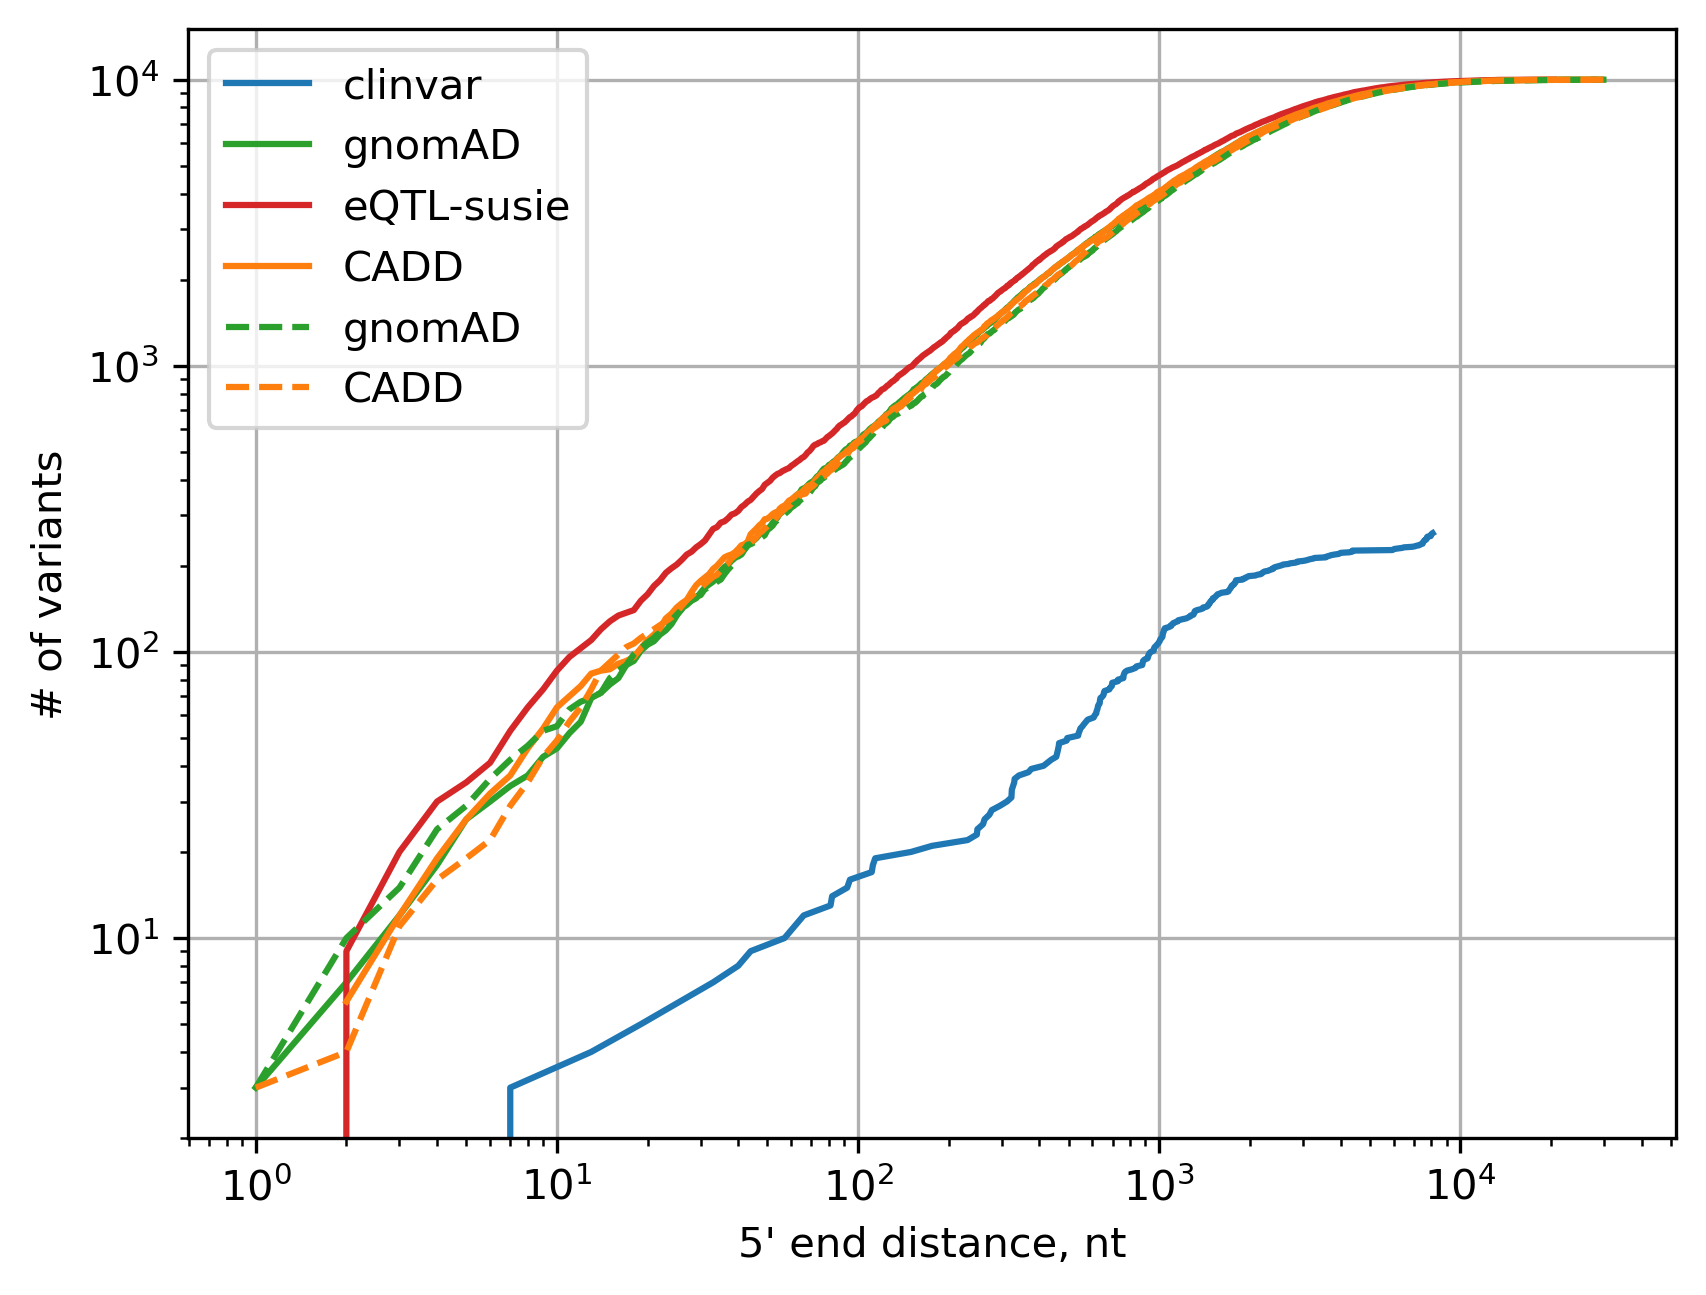

In [45]:
fig, ax = plt.subplots(dpi=300)

split_colors = {'clinvar':'tab:blue','gnomAD':'tab:green','eQTL-susie':'tab:red','CADD':'tab:orange',}

for split in splits:
    dist_df = utr_variants.loc[(utr_variants.label==1)&(utr_variants.split==split),['5prime_dist']].sort_values(by='5prime_dist')
    dist_df['n_vars'] = np.arange(len(dist_df))
    dist_df.drop_duplicates(subset='5prime_dist',keep='last',inplace=True)
    
    ax.plot(dist_df['5prime_dist']+1,dist_df['n_vars'],label=split,color=split_colors[split])


for split in ['gnomAD','CADD',]:
    dist_df = utr_variants.loc[(utr_variants.label==0)&(utr_variants.split==split),['5prime_dist']].sort_values(by='5prime_dist')
    dist_df['n_vars'] = np.arange(len(dist_df))
    dist_df.drop_duplicates(subset='5prime_dist',keep='last',inplace=True)
    
    ax.plot(dist_df['5prime_dist']+1,dist_df['n_vars'],label=split,color=split_colors[split],linestyle='--')


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("5' end distance, nt")
ax.set_ylabel("# of variants")
ax.grid(True)
ax.set_axisbelow(True)
ax.legend()